## *For annotated pre-processing and model tuning code, see file KNN_obesity_preproc&tuning_annotated.ipynb (this file contains non-annotated version of the same code to assist with the CV and visualization steps, which are annotated in this file)

In [1]:
!pip install ucimlrepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install pyarrow

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import label_binarize, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 

In [4]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation


In [5]:
print(X.dtypes,'\n')
print(y.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object 

NObeyesdad    object
dtype: object


In [6]:
print(X.isna().apply(sum),'\n')
print(y.isna().apply(sum))

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64 

NObeyesdad    0
dtype: int64


In [7]:
X['Gender'] = X['Gender'].map({'Female': 1, 'Male': 0})
X.rename(columns={'Gender': 'IsFemale?'}, inplace=True)

X['family_history_with_overweight'] = X['family_history_with_overweight'].map({'yes': 1, 'no': 0})

X['FAVC'] = X['FAVC'].map({'yes': 1, 'no': 0})

X['CAEC'] = X['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

X['SMOKE'] = X['SMOKE'].map({'yes': 1, 'no': 0})

X['SCC'] = X['SCC'].map({'yes': 1, 'no': 0})

X['CALC'] = X['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

X = pd.get_dummies(X, columns=['MTRANS'])

In [8]:
y['NObeyesdad'] = y['NObeyesdad'].map({'Normal_Weight': 0, 'Overweight_Level_I': 0, 'Overweight_Level_II': 0, 'Insufficient_Weight': 0, 'Obesity_Type_I': 1, 'Obesity_Type_II': 1, 'Obesity_Type_III': 1})
y.rename(columns={'NObeyesdad': 'IsObese?'}, inplace=True)

In [9]:
for xcolumn in X.columns:
    X[xcolumn] = X[xcolumn].astype(int)

for ycolumn in y.columns:
    y[ycolumn] = y[ycolumn].astype(int)

In [10]:
print(X.dtypes,'\n')
print(y.dtypes)

IsFemale?                         int64
Age                               int64
Height                            int64
Weight                            int64
family_history_with_overweight    int64
FAVC                              int64
FCVC                              int64
NCP                               int64
CAEC                              int64
SMOKE                             int64
CH2O                              int64
SCC                               int64
FAF                               int64
TUE                               int64
CALC                              int64
MTRANS_Automobile                 int64
MTRANS_Bike                       int64
MTRANS_Motorbike                  int64
MTRANS_Public_Transportation      int64
MTRANS_Walking                    int64
dtype: object 

IsObese?    int64
dtype: object


In [11]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()

for xcolumn in X.columns:
    X[xcolumn] = scaler1.fit_transform(X[[xcolumn]])
    X[xcolumn] = scaler2.fit_transform(X[[xcolumn]])

for ycolumn in y.columns:
    y[ycolumn] = scaler1.fit_transform(y[[ycolumn]])
    y[ycolumn] = scaler2.fit_transform(y[[ycolumn]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': list(range(1, 25)),'weights': ['uniform', 'distance']}
metrics = ['recall','f1','accuracy']

for metric in metrics:
    grid_search = GridSearchCV(knn, param_grid, scoring=metric)
    grid_search.fit(X_train, y_train)

    print(f"best_params for {metric}: {grid_search.best_params_}")

best_params for recall: {'n_neighbors': 22, 'weights': 'distance'}
best_params for f1: {'n_neighbors': 7, 'weights': 'distance'}
best_params for accuracy: {'n_neighbors': 7, 'weights': 'distance'}


In [60]:
def knn_funct(X,y, test_size=0.2, n_neighbors=5, weights='uniform'):

    #tt split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    #fit
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    #predict
    y_pred = knn.predict(X_test)

    #evaluate
    rec = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    return {'model': knn, 
            'predictions': y_pred, 
            'metrics': {
                'recall': rec, 
                'f1_score': F1, 
                'accuracy': acc
            },
            'ttsplit': {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
           }
    
    print(f"Sensitivity: {rec:.2f}")
    print(f"F1 Score: {F1:.2f}")
    print(f"Accuracy: {acc:.2f}")

# Function returns dictionary with model, predicted values, metrics (recall, F1, accuracy), and train/test sets

## CV and Visualization (annotated code)

In [61]:
# Run knn on our dataset with 15 neighbors and weights set to "distance" (this was previously established with GridSearch CV)
knn15 = knn_funct(X,y, n_neighbors=15, weights='distance')
knn15['model'] # show model

{'model': KNeighborsClassifier(),
 'predictions': array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1.,

In [62]:
# Run knn on our dataset with 7 neighbors and weights set to "distance" (this was previously established with GridSearch CV)
knn7 = knn_funct(X,y, n_neighbors=7, weights='distance')
knn7['model'] # show model

KNeighborsClassifier()

**Cross Validation**

In [18]:
from sklearn.model_selection import StratifiedKFold

In [63]:
# Continue with neighbors = 15 to maximize recall
knn15_model = knn15['model']
knn15_model

KNeighborsClassifier()

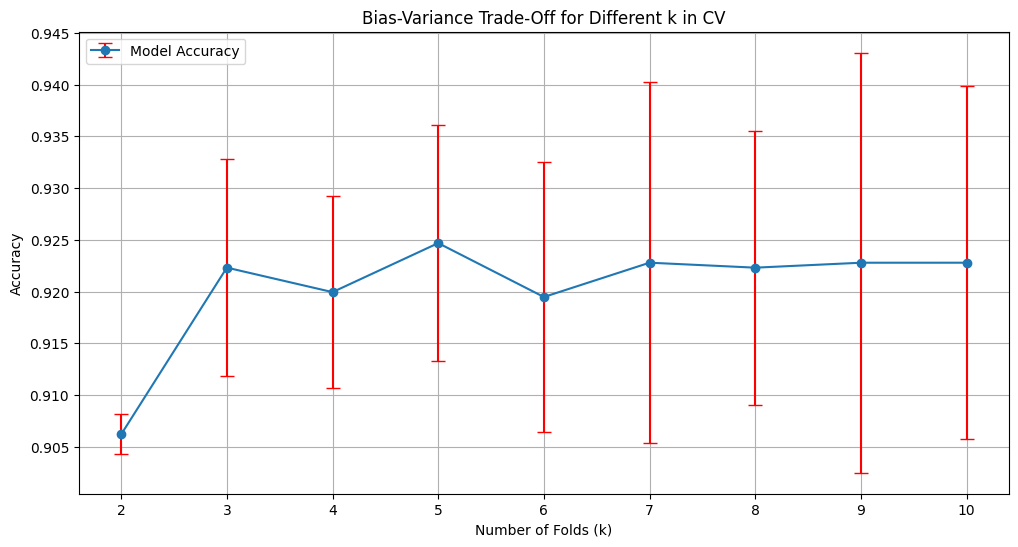

In [64]:
# Evaluate model with varying k for cross-validation to pick optimal number of splits
k_values = range(2, 11) # test values 2-10
mean_scores = [] # empty list to capture mean scores
std_scores = [] # empty list to capture standard deviations

warnings.simplefilter("ignore") # get rid of warnings
for k in k_values: # iterate through values 2-10
      cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # stratified k-fold CV with n_splits determined by for loop
      scores = cross_val_score(knn15_model, X, y, cv=cv, scoring='accuracy') # cv accuracy scores for our model
      mean_scores.append(np.mean(scores)) # add accuracy to list
      std_scores.append(np.std(scores)) # add standard deviation to list

# Plotting the bias and variance
plt.figure(figsize=(12, 6))

# Plot scores against values of k with error bars denoting standard deviation
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='o-', label='Model Accuracy', ecolor='red', capsize=5) 
plt.title('Bias-Variance Trade-Off for Different k in CV')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values) # x-ticks denoted by k values that were tested
plt.legend()
plt.grid(True) # add grid lines
plt.show()

In [65]:
# Define 5-fold Stratified Cross-Validation (based on graph above)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [66]:
# Get accuracy scores for each fold
cv_scores = cross_val_score(knn15_model, X, y, cv=cv)
cv_scores

array([0.91016548, 0.91232227, 0.93364929, 0.92890995, 0.93838863])

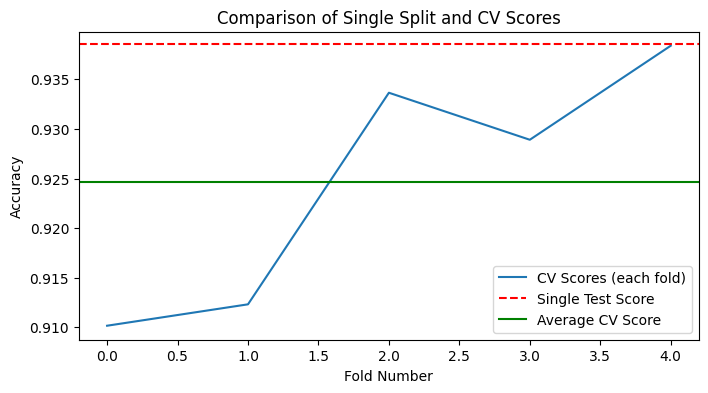

Single test score: 0.9385342789598109
Average CV Score: 0.9246871253627329


In [80]:
# Plot CV accuracy scores per fold and compare with single split score
plt.figure(figsize = (8,4))
plt.plot(cv_scores, label = 'CV Scores (each fold)') # plot cv accuracy
plt.title('Comparison of Single Split and CV Scores')
plt.axhline(y=knn15['metrics']['accuracy'], color='r', linestyle='--', label='Single Test Score') # add line for single test score
plt.axhline(y=np.mean(cv_scores), color='g', linestyle='-',
            label='Average CV Score') # add line for mean CV score
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print single test and average CV accuracy scores
print(f"Single test Score: {knn15['metrics']['accuracy']}\nAverage CV Score: {np.mean(cv_scores)}")

**Visualization**

In [68]:
from sklearn.metrics import roc_curve, auc

In [71]:
# Extract X_test from dict
X_test = knn15['ttsplit']['X_test']

# Probabilities for the positive class
y_probs = knn15_model.predict_proba(X_test)[:, 1]

In [72]:
# Get ROC (false pos rate and true pos rate)
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

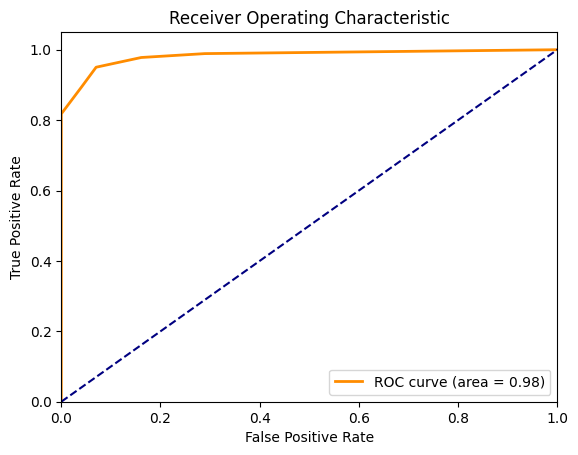

In [73]:
# Plotting ROC; higher curve = better model (curve, indicator that model isn't giving false positives)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') # plot false pos on x, true pos on y
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # add line to represent chance performance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [75]:
# Extract y_test and X_test from dict
y_test = knn15['ttsplit']['y_test']
X_test = knn15['ttsplit']['X_test']

# Get y_pred
y_pred = knn15_model.predict(X_test)

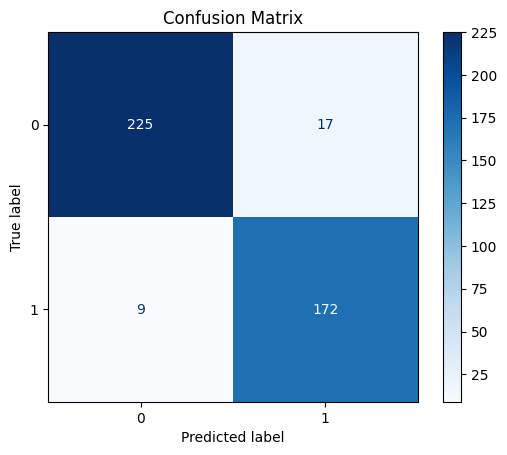

In [79]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred) # confusion matrix of test versus prediction
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix')
plt.show()